# Introduction

Every cell in the body is a direct descendant of the fertilized egg from which each of us developed, through time the DNA sequence of a cell acquires a set of differences from its progenitor, this variations are called somatic mutations _(Stratton, et al., 2009; Yates & Campbell, 2012)_. Somatic mutations can be classified by the type of change in the DNA sequence, substitutions, insertions, deletions, rearrangements and change in copy numbers. Variations can occur all over the genome, depending on the genome localization they will affect the protein structure, and can also be classified by this _(Lodish, et al., 2000; Tate, et al., 2018)_.  

All cancer arise as a result of a somatic mutation, that does not mean that all somatic variations in the DNA of cancer cells have been involved in development of the tumour. The ones that have been positively selected or “driver” mutations confer an advantage, the rest of the mutations are called “passenger” mutations, this type haven’t been selected, they just happened to be there _(Stratton, et al., 2009; Nik-Zainal, et al. 2012a)_. The evolution of cancer is a series events, constant acquisition of mutations and natural selection, these processes mark the genome, and a cancer’s life history is encrypted in the somatic mutations that we can find in its genome _(Nik-Zainal, et al., 2012b; Yates & Campbell, 2012)_. 

The catalogue of mutations have been used to tell the evolutionary history of tumors _(Popic, et al., 2014)_. Knowing the the evolution of a tumor is important because, as in evolution, it lets us understand the subpopulations of cells present in a tumor and the biological processes, and can be used in a clinical decision _(Fisher, et al., 2013)_. 

An important thing in history is time, knowing how long have been the tumor evolving can help in diagnosis, tumor classification, prognosis and treatment. Time can lead us to determine which pattern of mutation interactions, such as mutual exclusivity or co-occurrence, is in action, which  is especially important because such patterns help finding unknown functional interactions that might be important tumor classification and multi target treatment _(Ochoa, et al., 2019)_. 

As the evolutive history, the age of a tumor can be inferred from the catalogue of mutations, in this paper we will present a method to determine the evolutive age of a tumor in terms of the somatic mutations with low or no selection pressure present in the cancer genome. Passenger mutations or mutations that do not confer advantage to a cell are useful to determine the age of a tumor 

Studies show that the accumulation of mutations can be accelerated due to genome instability, increased sensitivity to mutagenic agents and breakdown of genomic maintenance _(Hanahan & Weinberg, 2011; Negrini, et al., 2010)_, according to this we can make the assumption that the mutations present before the tumor started to evolve are negligible in number. 

- ¿Por qué usar las que no tienen selección? (Secuencias conservadas y evolución)
- ¿Cuales son las mutaciones que tienen un efecto neutral?

In [72]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
from scipy import stats
import math
%matplotlib inline

# Methods and Data:

Data used in this paper is available online at https://gdac.broadinstitute.org. The data set used in this paper is the BRCA-TP.maf.annotated file of the Breast invasive carcinoma in the mutation analysis browser in the section mutation assessor, methods and data, download results, analysis results, this file contains 76673 mutations with 356 annotations as variables.

### Original data:

In [73]:
# Importando el archivo .maf anotado (Obtenido de: http://firebrowse.org)
archivomaf = 'BRCA-TP.maf.annotated'
#encoding = "ISO-8859-1" (Se obtenia un error, se encontró que agregando esto, funciono)
mafData = pd.read_csv(archivomaf, sep='\t', encoding = "ISO-8859-1")

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (50,57,62,63,67,70,72,73,75,76,105,108,109,113,122,124,131,132,135,136,145,150,151,163,164,179,205,302,303,304,318,319,320,354) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Data was subjected to an analysis under the scope of the project objectives to select the variables that could be used to determine the age of the tumor. From 356 variables, nine (9) were selected. The variables selected helped us know different characteristics of the mutation including: location, classification and functional impact (Reva, et al., 2011). 

### Data preprocess:

In [74]:
# Una copia de las columnas que quiero en un nuevo DataFrame:
mafToSort = mafData[['Hugo_Symbol', 'Chromosome', 'Variant_Classification',
       'Variant_Type', 'i_HGNC_LocusType', 'is_coding', 'patient',
       'MA_Func.Impact', 'MA_FI.score']].copy()

# Cambiandole el nombre de MA_Func.Impact a MA_Func_Impact y MA_FI.score a MA_FI_score:
mafToSort.columns = ['Hugo_Symbol', 'Chromosome', 'Variant_Classification',
       'Variant_Type', 'i_HGNC_LocusType', 'is_coding', 'patient',
       'MA_Func_Impact', 'MA_FI_score']

print('Mutaciones: ' + str(mafToSort.shape[0]) + ' Variables: ' + str(mafToSort.shape[1]))

# Organizando por identificación de paciente:
data_SortPatient = mafToSort.sort_values(['patient','Variant_Classification', 'i_HGNC_LocusType'])

# Los NaN van a ser '-'
data = data_SortPatient.fillna('0')

# Guardo el archivo: 
# Con las columnas que quiero
# Ordenado por: paciente, Variant Classification y locus type
data_SortPatient.to_csv('maf_OrdenadoxPaciente.txt', sep='\t', encoding='utf-8')

Mutaciones: 76673 Variables: 9


In [75]:
print('Mutaciones: ' + str(mafData.shape[0]) + ' Variables: ' + str(mafData.shape[1]))

Mutaciones: 76673 Variables: 356


Some measurements based on the count of passenger mutations were performed. Variant classification was the selection criteria to determine the mutations as passenger, silent, intergenic region and intron mutations were taken into account, functional impact determined by mutationassessor was also reviewed, mutations with functional impact score (FIS) lower than 1.9 were classified as polymorphic variants, which is neutral or low functional impact (Reva, et al., 2011).   

### Data process:

#### Medidas

+ m1: silent
+ m2: Intergenic Regions
+ m3: Introns
+ m4: neutral&low FI [Determinado por el score <1.9] (El impacto funcional solo está dado para Missense_Mutations)
+ m5: suma silent, intergenic e intrones

In [76]:
# Si se necesita cargar de nuevo el archivo:
# maf = 'maf_OrdenadoxPaciente.txt'
#data = pd.read_csv(maf, sep='\t')

In [77]:
dg = data.groupby('patient')
m = {'patient':0, 'mut tot':0, 'silent':0, 'igr':0, 'intron':0, 'low&neutral FI':0, 'Score_Menor':0}
Paciente = []
mut_tot = []
silent_mut = []
intergenic = []
intron_mut = []
suma_s_igr_int = []
lynfi = []
fisMen19 = []
l = 0
n = 0
ln = 0
smenor19=0

for (patient, Pgroup) in dg:
    #print('\n', patient, '\n')
    m['patient'] = patient
    m['mut tot'] = Pgroup.shape[0]
    #print('mut tot:',Pgroup.shape[0])
    vgg = Pgroup.groupby('Variant_Classification')
    fig = Pgroup.groupby('MA_Func_Impact')
    fis = Pgroup.groupby('MA_FI_score')
    for (Variant_Classification, Vgroup) in vgg:
        if Variant_Classification == 'Silent':
            m['silent'] = Vgroup.shape[0]
            #print(Variant_Classification, ':', Vgroup.shape[0])
        if Variant_Classification == 'IGR':
            m['igr'] = Vgroup.shape[0]
            #print(Variant_Classification, ':', Vgroup.shape[0])
        if Variant_Classification =='Intron':
            m['intron'] = Vgroup.shape[0]
            #print(Variant_Classification, ':', Vgroup.shape[0])
            #print(Variant_Classification, ':', Vgroup.shape[0])
    for(MA_Func_Impact, Fgroup) in fig:
        if MA_Func_Impact == 'low' :
            l = Fgroup.shape[0]
            #print(MA_Func_Impact,':', Fgroup.shape[0])
        if MA_Func_Impact == 'neutral':
            n = Fgroup.shape[0]
            #print(MA_Func_Impact,':', Fgroup.shape[0])
        ln = l+n
        m['low&neutral FI'] = ln
        #print(MA_Func_Impact,':', Fgroup.shape[0]) 
    for(MA_FI_score, FSgroup) in fis:
        if float(MA_FI_score) <= 1.9 and float(MA_FI_score) > 1.9 :
            m['Score_Menor']=FSgroup.shape[0]
            
    tt = m['silent'] + m['igr'] + m['intron']     
    Paciente.append(m['patient'])
    mut_tot.append(m['mut tot'])
    silent_mut.append(m['silent'])
    intergenic.append(m['igr'])
    intron_mut.append(m['intron'])
    lynfi.append(m['low&neutral FI'])
    fisMen19.append(m['Score_Menor'])
    suma_s_igr_int.append(tt)

paraDf = {'Patient_Id': Paciente, 'Total_Mutations': mut_tot, 'Silent_Mutations': silent_mut, 'IGR_Mutations': intergenic,
         'Intron_Mut': intron_mut, 'Low_Neutral_FI': lynfi, 'Score_Menor': fisMen19 , 'Suma_S_IGR_IN': suma_s_igr_int}

medidas = pd.DataFrame(paraDf)
# Guardando los datos sacados a un archivo de texto.
medidas.to_csv('medidasxpaciente.txt', sep='\t', encoding='utf-8')

*************************************************************
¿Esto si lo vamos a hacer? Mapeo de la probabilidad etiológica de las mutaciones: para realizar este mapeo se realizará un script en Python que correlacione el catálogo de mutaciones encontradas para una muestra con el catálogo de firmas mutacionales obtenido anteriormente y se encontrará la probabilidad de que cada mutación sea generada por determinadas firmas. Los resultados obtenidos en este análisis se pondrán de manera gráfica.

# Results

- m1 vs m2 (Silent Mutations vs. Intergenic Regions)
- m1 vs m3 (Silent mutations vs. Introns)
- m2 vs m3 (Intergenic Regions vs. Introns)
- m5 vs Total

In [78]:
medsOrden = medidas.sort_values(by=['Total_Mutations', 'Patient_Id'], ascending=False)
medsOrden.head(5)

,IGR_Mutations,Intron_Mut,Low_Neutral_FI,Patient_Id,Score_Menor,Silent_Mutations,Suma_S_IGR_IN,Total_Mutations
274,15,38,1883,TCGA-AN-A046-01A-21W-A050-09,0,937,990,5278
239,17,40,1693,TCGA-AC-A23H-01A-11D-A159-09,0,1051,1108,4509
231,7,25,920,TCGA-A8-A0A6-01A-12W-A071-09,0,891,923,2979
66,5,19,486,TCGA-A2-A0T5-01A-21D-A099-09,0,325,349,1387
568,3,10,387,TCGA-BH-A18G-01A-11D-A12B-09,0,299,312,1316


In [79]:
print('General description of the data: ')
medsOrden.describe()

General description of the data: 


,IGR_Mutations,Intron_Mut,Low_Neutral_FI,Score_Menor,Silent_Mutations,Suma_S_IGR_IN,Total_Mutations
count,978.000000,978.000000,978.000000,978.0,978.000000,978.000000,978.000000
mean,1.672802,1.979550,26.853783,0.0,17.768916,21.421268,78.397751
std,2.261623,3.956984,94.000665,0.0,60.036408,62.745334,266.520793
min,0.000000,0.000000,2.000000,0.0,1.000000,3.000000,1.000000
25%,1.000000,1.000000,7.000000,0.0,5.000000,8.000000,24.000000
50%,1.000000,1.000000,12.000000,0.0,8.000000,11.000000,37.000000
75%,2.000000,2.000000,22.000000,0.0,14.000000,18.000000,65.000000
max,17.000000,40.000000,1883.000000,0.0,1051.000000,1108.000000,5278.000000


In [98]:
soloMeds = medsOrden[['IGR_Mutations', 'Intron_Mut', 'Low_Neutral_FI',
                      'Silent_Mutations', 'Suma_S_IGR_IN', 'Total_Mutations']].copy()
soloMeds.columns

Index(['IGR_Mutations', 'Intron_Mut', 'Low_Neutral_FI', 'Silent_Mutations',
       'Suma_S_IGR_IN', 'Total_Mutations'],
      dtype='object')

In [81]:
medsOrden.columns

Index(['IGR_Mutations', 'Intron_Mut', 'Low_Neutral_FI', 'Patient_Id',
       'Score_Menor', 'Silent_Mutations', 'Suma_S_IGR_IN', 'Total_Mutations'],
      dtype='object')

## Total mutations

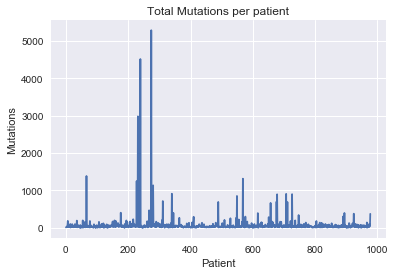

In [99]:
#x=np.arange(len(medsOrden))
#plt.bar(x, height = medsOrden.Total_Mutations)
plt.plot(mut_tot)
plt.title('Total Mutations per patient')
plt.ylabel('Mutations')
plt.xlabel('Patient')

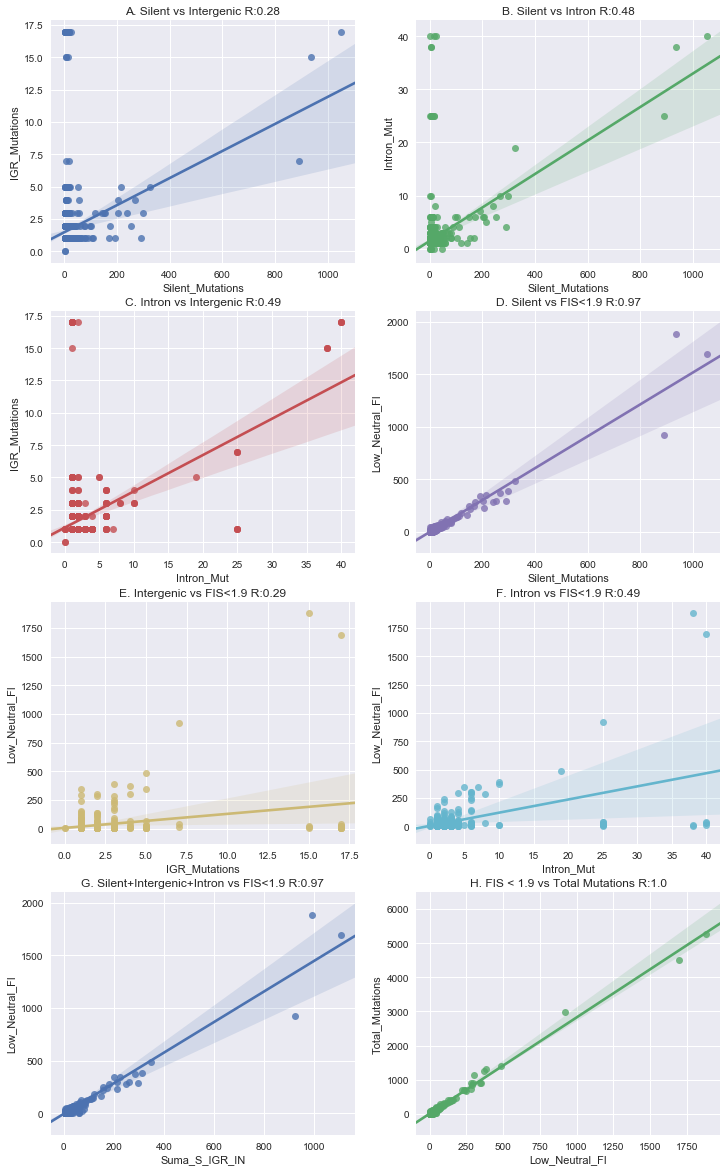

In [100]:
fig, axs = plt.subplots(nrows=4, ncols=2)
fig.set_figwidth(12)
fig.set_figheight(20.5)

cor1 = np.corrcoef(medsOrden.Silent_Mutations, medsOrden.IGR_Mutations)
cor1=cor1[0,1]
cor2 = np.corrcoef(medsOrden.Silent_Mutations,medsOrden.Intron_Mut)
cor2=cor2[0,1]
cor3= np.corrcoef(medsOrden.Intron_Mut, medsOrden.IGR_Mutations)
cor3=cor3[0,1]
cor4 = np.corrcoef(medsOrden.Silent_Mutations, medsOrden.Low_Neutral_FI)
cor4=cor4[0,1]
cor5=np.corrcoef(medsOrden.IGR_Mutations, medsOrden.Low_Neutral_FI)
cor5=cor5[0,1]
cor6=np.corrcoef(medsOrden.Intron_Mut, medsOrden.Low_Neutral_FI)
cor6=cor6[0,1]
cor7=np.corrcoef(medsOrden.Suma_S_IGR_IN, medsOrden.Low_Neutral_FI)
cor7=cor7[0,1]
cor8=np.corrcoef(medsOrden.Low_Neutral_FI, medsOrden.Total_Mutations)
cor8=cor8[0,1]

tit1='A. Silent vs Intergenic R:'+str(round((cor1), 2))
tit2= 'B. Silent vs Intron R:' + str(round((cor2), 2))
tit3= 'C. Intron vs Intergenic R:' + str(round((cor3), 2))
tit4='D. Silent vs FIS<1.9 R:' + str(round((cor4), 2))
tit5='E. Intergenic vs FIS<1.9 R:' + str(round((cor5), 2))
tit6='F. Intron vs FIS<1.9 R:' + str(round((cor6), 2))
tit7= 'G. Silent+Intergenic+Intron vs FIS<1.9 R:' + str(round((cor7), 2))
tit8 = 'H. FIS < 1.9 vs Total Mutations R:' + str(round((cor8), 2))

sns.regplot(medsOrden.Silent_Mutations, medsOrden.IGR_Mutations, ax=axs[0,0]).set_title(tit1)
sns.regplot(medsOrden.Silent_Mutations,medsOrden.Intron_Mut, ax=axs[0,1]).set_title(tit2)
sns.regplot(medsOrden.Intron_Mut, medsOrden.IGR_Mutations, ax=axs[1,0]).set_title(tit3)
sns.regplot(medsOrden.Silent_Mutations, medsOrden.Low_Neutral_FI, ax=axs[1,1]).set_title(tit4)
sns.regplot(medsOrden.IGR_Mutations, medsOrden.Low_Neutral_FI, ax=axs[2,0]).set_title(tit5)
sns.regplot(medsOrden.Intron_Mut, medsOrden.Low_Neutral_FI, ax=axs[2,1]).set_title(tit6)
sns.regplot(medsOrden.Suma_S_IGR_IN, medsOrden.Low_Neutral_FI, ax=axs[3,0]).set_title(tit7)
sns.regplot(medsOrden.Low_Neutral_FI, medsOrden.Total_Mutations).set_title(tit8)

Las gráficas presentadas anteriormente (A-F) son las relacione entre las diferentes medidas de edad de un tumor realizadas en terminos de número de mutaciones. Las medidas realizadas fueron: 

+ m1 : Número de mutaciones silenciosas (silent).
+ m2 : Número de mutaciones en regiones intergénicas (IGR)
+ m3 : Número de mutaciones en intrones (intron).
+ m4 : Sumatoria de m1, m2 y m3 (sum123).
+ m5 : Mutaciones con Functional Impact Score (FIS) menor a 1.9 (FIS < 1.9).

__A.__ Relacion entre m1 y m2 (silent vs IGR), coeficiente de relación de 0.28.<br>
__B.__ Relación entre m1 y m3 (silent vs intron), coeficiente de relación (R) de 0.48. <br>
__C.__ Relación entre m2 y m3 (IGR vs intron), con un R de 0.49. <br> 
__D.__ Relación entre m1 y m5 (silent vs FIS < 1.9), R=0.98. <br>
__E.__ Relación entre m2 y m5 (IGR vs FIS < 1.9), R=0.28. <br>
__F.__ Grafica de relacion entre m3 y m5 (intron vs FIS < 1.9), R=0.48.<br>
__G.__ Relación m4 vs m5 (sum123 vs FIS < 1.9), R=0.98.<br>
__H.__ Relación entre FIS < 1.9 vs Mutaciones Totales, R=1.0, lo que me dice que la mayoría de las mutaciones en el genoma del cancer son mutaciones con un impacto funcional bajo o neutral.

1. Outliers con boxplots, saco los que quedan afuera de las rayas.
2. volver a hacer las graficas
3. Umbral minimo de mutaciones (si se hace que defender esto, y decir por qué el umbral)
4. Ver si hay heteroblabla y si si sacar o raiz cuadrada o log de cada una de las medidas.

HABLAR CON ALEX!!

Métodos para quitar outliers: 

https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba <br>
- Zscore
- Boxplots (Rango intercuartilico)

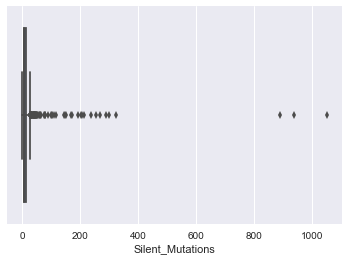

In [101]:
sns.boxplot(soloMeds.Silent_Mutations)

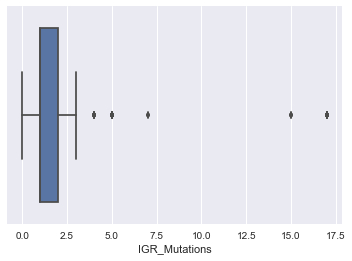

In [102]:
sns.boxplot(soloMeds.IGR_Mutations)

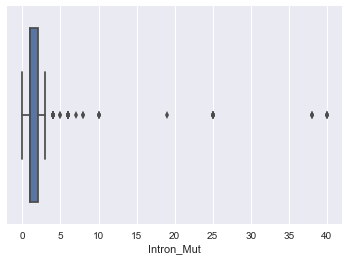

In [103]:
sns.boxplot(soloMeds.Intron_Mut)

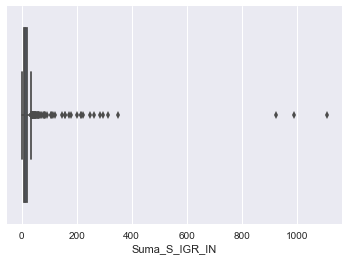

In [104]:
sns.boxplot(soloMeds.Suma_S_IGR_IN)

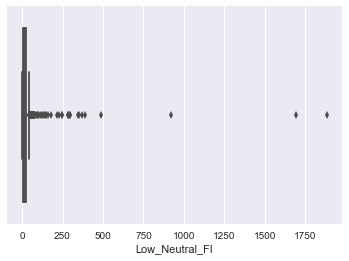

In [105]:
sns.boxplot(soloMeds.Low_Neutral_FI)

In [116]:
# Zscore
z = np.abs(stats.zscore(soloMeds))
#print(z)

def outliers_z_score(ys):
    threshold = 3

    mean_y = np.mean(ys)
    stdev_y = np.std(ys)
    z_scores = [(y - mean_y) / stdev_y for y in ys]
    return np.where(np.abs(z_scores) > threshold)

In [107]:
#Inter Quartile Range:
Q1 = soloMeds.quantile(0.25)
Q3 = soloMeds.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

#print(soloMeds < (Q1 - 1.5 * IQR)) |(soloMeds > (Q3 + 1.5 * IQR))

IGR_Mutations        1.0
Intron_Mut           1.0
Low_Neutral_FI      15.0
Silent_Mutations     9.0
Suma_S_IGR_IN       10.0
Total_Mutations     41.0
dtype: float64


In [108]:
soloMeds_out_z = soloMeds[(z < 3).all(axis=1) | (z > 3).all(axis=1)]
print(soloMeds.shape)
print(soloMeds_out_z.shape)
soloMeds_out = soloMeds[~((soloMeds < (Q1 - 1.5 * IQR)) |(soloMeds > (Q3 + 1.5 * IQR))).any(axis=1)]
print(soloMeds.shape)
print (soloMeds_out.shape)


(978, 6)
(944, 6)
(978, 6)
(800, 6)


Para ver de manera gráfica los outliers con boxplots, donde igual quedan algunos datos por fuera de las cajas pero no parecen ser 

### Con IQR:

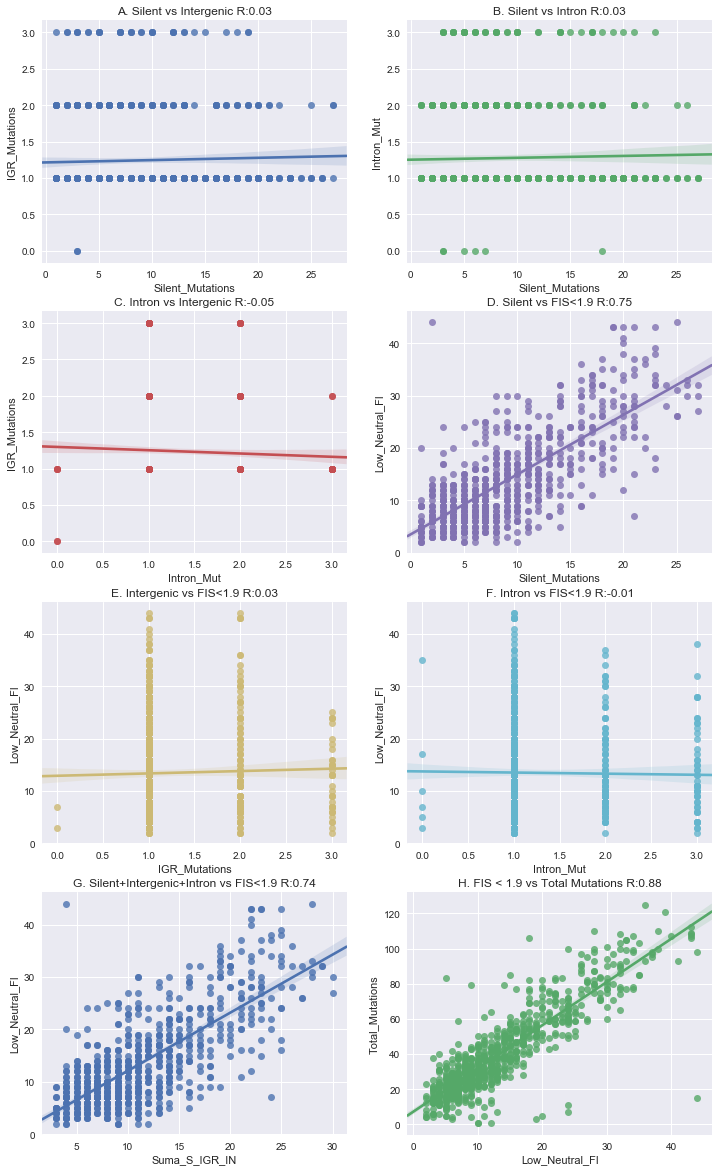

In [110]:
fig, axs = plt.subplots(nrows=4, ncols=2)
fig.set_figwidth(12)
fig.set_figheight(20.5)

cor1 = np.corrcoef(soloMeds_out.Silent_Mutations, soloMeds_out.IGR_Mutations)
cor1=cor1[0,1]
cor2 = np.corrcoef(soloMeds_out.Silent_Mutations,soloMeds_out.Intron_Mut)
cor2=cor2[0,1]
cor3= np.corrcoef(soloMeds_out.Intron_Mut, soloMeds_out.IGR_Mutations)
cor3=cor3[0,1]
cor4 = np.corrcoef(soloMeds_out.Silent_Mutations, soloMeds_out.Low_Neutral_FI)
cor4=cor4[0,1]
cor5=np.corrcoef(soloMeds_out.IGR_Mutations, soloMeds_out.Low_Neutral_FI)
cor5=cor5[0,1]
cor6=np.corrcoef(soloMeds_out.Intron_Mut, soloMeds_out.Low_Neutral_FI)
cor6=cor6[0,1]
cor7=np.corrcoef(soloMeds_out.Suma_S_IGR_IN, soloMeds_out.Low_Neutral_FI)
cor7=cor7[0,1]
cor8=np.corrcoef(soloMeds_out.Low_Neutral_FI, soloMeds_out.Total_Mutations)
cor8=cor8[0,1]

tit1='A. Silent vs Intergenic R:'+str(round((cor1), 2))
tit2= 'B. Silent vs Intron R:' + str(round((cor2), 2))
tit3= 'C. Intron vs Intergenic R:' + str(round((cor3), 2))
tit4='D. Silent vs FIS<1.9 R:' + str(round((cor4), 2))
tit5='E. Intergenic vs FIS<1.9 R:' + str(round((cor5), 2))
tit6='F. Intron vs FIS<1.9 R:' + str(round((cor6), 2))
tit7= 'G. Silent+Intergenic+Intron vs FIS<1.9 R:' + str(round((cor7), 2))
tit8 = 'H. FIS < 1.9 vs Total Mutations R:' + str(round((cor8), 2))

sns.regplot(soloMeds_out.Silent_Mutations,soloMeds_out.IGR_Mutations, ax=axs[0,0]).set_title(tit1)
sns.regplot(soloMeds_out.Silent_Mutations,soloMeds_out.Intron_Mut, ax=axs[0,1]).set_title(tit2)
sns.regplot(soloMeds_out.Intron_Mut, soloMeds_out.IGR_Mutations, ax=axs[1,0]).set_title(tit3)
sns.regplot(soloMeds_out.Silent_Mutations,soloMeds_out.Low_Neutral_FI, ax=axs[1,1]).set_title(tit4)
sns.regplot(soloMeds_out.IGR_Mutations, soloMeds_out.Low_Neutral_FI, ax=axs[2,0]).set_title(tit5)
sns.regplot(soloMeds_out.Intron_Mut, soloMeds_out.Low_Neutral_FI, ax=axs[2,1]).set_title(tit6)
sns.regplot(soloMeds_out.Suma_S_IGR_IN, soloMeds_out.Low_Neutral_FI, ax=axs[3,0]).set_title(tit7)
sns.regplot(soloMeds_out.Low_Neutral_FI, soloMeds_out.Total_Mutations).set_title(tit8)

Las graficas anteriores muestran la relación entre las diversas medidas luego de remover los outliers con el método del rango intercuartilico.
__A.__ Relacion entre m1 y m2 (silent vs IGR), coeficiente de relación de 0.03 <br>
__B.__ Relación entre m1 y m3 (silent vs intron), coeficiente de relación (R) de 0.03. <br>
__C.__ Relación entre m2 y m3 (IGR vs intron), con un R de -0.05. <br> 
__D.__ Relación entre m1 y m5 (silent vs FIS < 1.9), R=0.75. <br>
__E.__ Relación entre m2 y m5 (IGR vs FIS < 1.9), R=0.03. <br>
__F.__ Grafica de relacion entre m3 y m5 (intron vs FIS < 1.9), R=-0.01.<br>
__G.__ Relación m4 vs m5 (sum123 vs FIS < 1.9), R=0.74.<br>
__H.__ Relación entre FIS < 1.9 vs Mutaciones Totales, R=0.88.

## Z score con sqrt

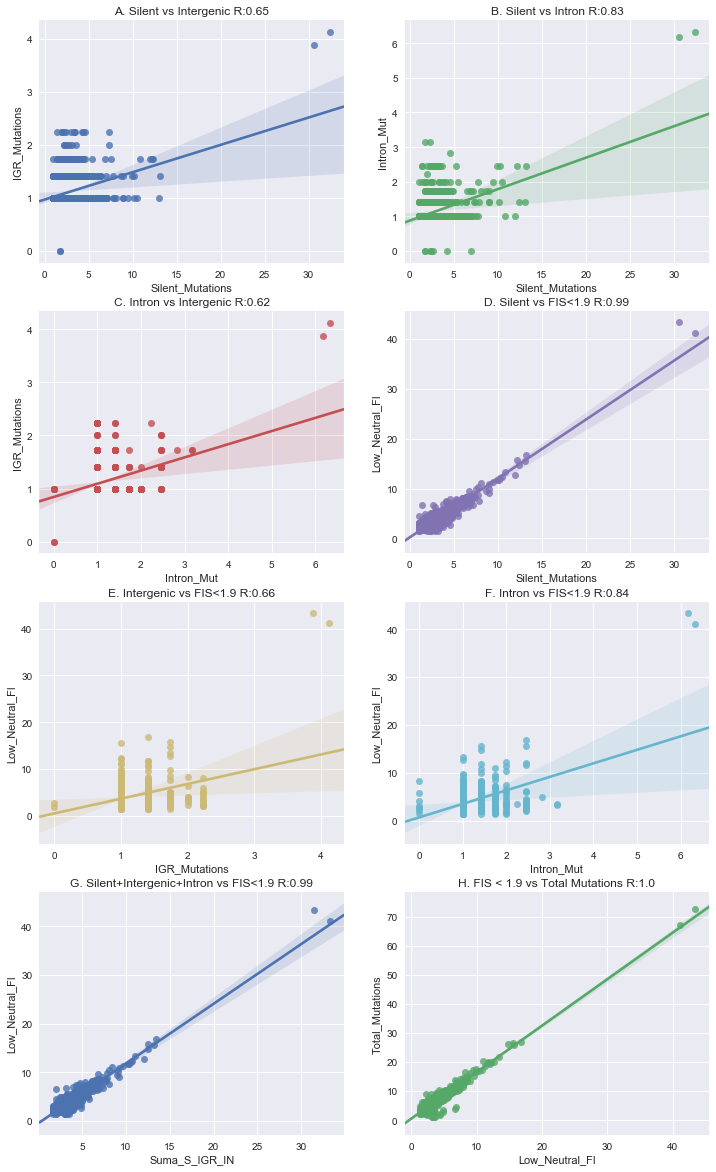

In [113]:
fig, axs = plt.subplots(nrows=4, ncols=2)
fig.set_figwidth(12)
fig.set_figheight(20.5)

cor1 = np.corrcoef(soloMeds_out_z.Silent_Mutations, soloMeds_out_z.IGR_Mutations)
cor1=cor1[0,1]
cor2 = np.corrcoef(soloMeds_out_z.Silent_Mutations,soloMeds_out_z.Intron_Mut)
cor2=cor2[0,1]
cor3= np.corrcoef(soloMeds_out_z.Intron_Mut, soloMeds_out_z.IGR_Mutations)
cor3=cor3[0,1]
cor4 = np.corrcoef(soloMeds_out_z.Silent_Mutations, soloMeds_out_z.Low_Neutral_FI)
cor4=cor4[0,1]
cor5=np.corrcoef(soloMeds_out_z.IGR_Mutations, soloMeds_out_z.Low_Neutral_FI)
cor5=cor5[0,1]
cor6=np.corrcoef(soloMeds_out_z.Intron_Mut, soloMeds_out_z.Low_Neutral_FI)
cor6=cor6[0,1]
cor7=np.corrcoef(soloMeds_out_z.Suma_S_IGR_IN, soloMeds_out_z.Low_Neutral_FI)
cor7=cor7[0,1]
cor8=np.corrcoef(soloMeds_out_z.Low_Neutral_FI, soloMeds_out_z.Total_Mutations)
cor8=cor8[0,1]

tit1='A. Silent vs Intergenic R:'+str(round((cor1), 2))
tit2= 'B. Silent vs Intron R:' + str(round((cor2), 2))
tit3= 'C. Intron vs Intergenic R:' + str(round((cor3), 2))
tit4='D. Silent vs FIS<1.9 R:' + str(round((cor4), 2))
tit5='E. Intergenic vs FIS<1.9 R:' + str(round((cor5), 2))
tit6='F. Intron vs FIS<1.9 R:' + str(round((cor6), 2))
tit7= 'G. Silent+Intergenic+Intron vs FIS<1.9 R:' + str(round((cor7), 2))
tit8 = 'H. FIS < 1.9 vs Total Mutations R:' + str(round((cor8), 2))

sns.regplot(np.sqrt(soloMeds_out_z.Silent_Mutations), np.sqrt(soloMeds_out_z.IGR_Mutations), ax=axs[0,0]).set_title(tit1)
sns.regplot(np.sqrt(soloMeds_out_z.Silent_Mutations),np.sqrt(soloMeds_out_z.Intron_Mut), ax=axs[0,1]).set_title(tit2)
sns.regplot(np.sqrt(soloMeds_out_z.Intron_Mut), np.sqrt(soloMeds_out_z.IGR_Mutations), ax=axs[1,0]).set_title(tit3)
sns.regplot(np.sqrt(soloMeds_out_z.Silent_Mutations),np.sqrt(soloMeds_out_z.Low_Neutral_FI), ax=axs[1,1]).set_title(tit4)
sns.regplot(np.sqrt(soloMeds_out_z.IGR_Mutations), np.sqrt(soloMeds_out_z.Low_Neutral_FI), ax=axs[2,0]).set_title(tit5)
sns.regplot(np.sqrt(soloMeds_out_z.Intron_Mut), np.sqrt(soloMeds_out_z.Low_Neutral_FI), ax=axs[2,1]).set_title(tit6)
sns.regplot(np.sqrt(soloMeds_out_z.Suma_S_IGR_IN), np.sqrt(soloMeds_out_z.Low_Neutral_FI), ax=axs[3,0]).set_title(tit7)
sns.regplot(np.sqrt(soloMeds_out_z.Low_Neutral_FI),np.sqrt(soloMeds_out_z.Total_Mutations)).set_title(tit8)

Las graficas anteriores muestran la relación entre las diversas medidas luego de remover los outliers con el método de puntaje estandar (z-score) y haber sacado la raíz cuadrada. 
__A.__ Relacion entre m1 y m2 (silent vs IGR), coeficiente de relación de 0.65 <br>
__B.__ Relación entre m1 y m3 (silent vs intron), coeficiente de relación (R) de 0.83 <br>
__C.__ Relación entre m2 y m3 (IGR vs intron), con un R de 0.62 <br> 
__D.__ Relación entre m1 y m5 (silent vs FIS < 1.9), R=0.99 <br>
__E.__ Relación entre m2 y m5 (IGR vs FIS < 1.9), R=0.66 <br>
__F.__ Grafica de relacion entre m3 y m5 (intron vs FIS < 1.9), R=0.84<br>
__G.__ Relación m4 vs m5 (sum123 vs FIS < 1.9), R=0.99<br>
__H.__ Relación entre FIS < 1.9 vs Mutaciones Totales, R=1.0

# Los mas lindos de cada uno

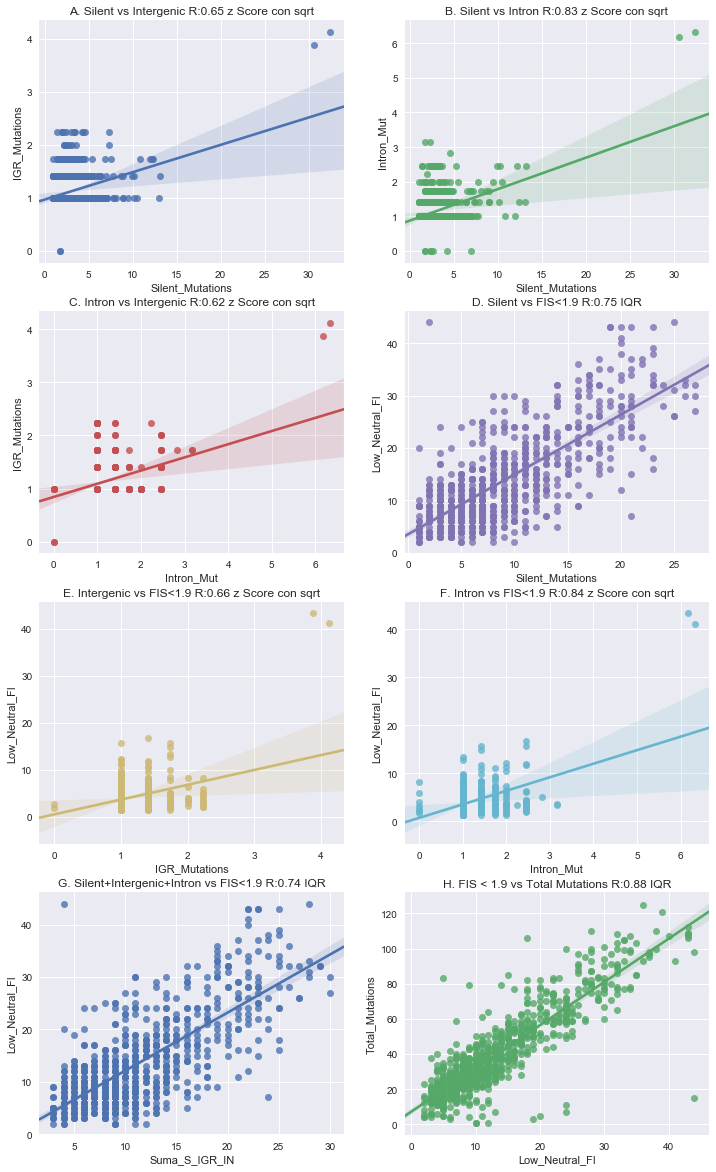

In [115]:
fig, axs = plt.subplots(nrows=4, ncols=2)
fig.set_figwidth(12)
fig.set_figheight(20.5)

cor1 = np.corrcoef(soloMeds_out_z.Silent_Mutations, soloMeds_out_z.IGR_Mutations)
cor1=cor1[0,1]
cor2 = np.corrcoef(soloMeds_out_z.Silent_Mutations,soloMeds_out_z.Intron_Mut)
cor2=cor2[0,1]
cor3= np.corrcoef(soloMeds_out_z.Intron_Mut, soloMeds_out_z.IGR_Mutations)
cor3=cor3[0,1]
cor4 = np.corrcoef(soloMeds_out.Silent_Mutations, soloMeds_out.Low_Neutral_FI)
cor4=cor4[0,1]
cor5=np.corrcoef(soloMeds_out_z.IGR_Mutations, soloMeds_out_z.Low_Neutral_FI)
cor5=cor5[0,1]
cor6=np.corrcoef(soloMeds_out_z.Intron_Mut, soloMeds_out_z.Low_Neutral_FI)
cor6=cor6[0,1]
cor7=np.corrcoef(soloMeds_out.Suma_S_IGR_IN, soloMeds_out.Low_Neutral_FI)
cor7=cor7[0,1]
cor8=np.corrcoef(soloMeds_out.Low_Neutral_FI, soloMeds_out.Total_Mutations)
cor8=cor8[0,1]

tit1='A. Silent vs Intergenic R:'+str(round((cor1), 2)) + " z Score con sqrt"
tit2= 'B. Silent vs Intron R:' + str(round((cor2), 2)) + " z Score con sqrt"
tit3= 'C. Intron vs Intergenic R:' + str(round((cor3), 2)) + " z Score con sqrt"
tit4='D. Silent vs FIS<1.9 R:' + str(round((cor4), 2)) + " IQR"
tit5='E. Intergenic vs FIS<1.9 R:' + str(round((cor5), 2)) + " z Score con sqrt"
tit6='F. Intron vs FIS<1.9 R:' + str(round((cor6), 2)) + " z Score con sqrt"
tit7= 'G. Silent+Intergenic+Intron vs FIS<1.9 R:' + str(round((cor7), 2))  + " IQR"
tit8 = 'H. FIS < 1.9 vs Total Mutations R:' + str(round((cor8), 2)) +" IQR"


sns.regplot(np.sqrt(soloMeds_out_z.Silent_Mutations), np.sqrt(soloMeds_out_z.IGR_Mutations), ax=axs[0,0]).set_title(tit1)
sns.regplot(np.sqrt(soloMeds_out_z.Silent_Mutations),np.sqrt(soloMeds_out_z.Intron_Mut), ax=axs[0,1]).set_title(tit2)
sns.regplot(np.sqrt(soloMeds_out_z.Intron_Mut), np.sqrt(soloMeds_out_z.IGR_Mutations), ax=axs[1,0]).set_title(tit3)
sns.regplot(soloMeds_out.Silent_Mutations,soloMeds_out.Low_Neutral_FI, ax=axs[1,1]).set_title(tit4)
sns.regplot(np.sqrt(soloMeds_out_z.IGR_Mutations), np.sqrt(soloMeds_out_z.Low_Neutral_FI), ax=axs[2,0]).set_title(tit5)
sns.regplot(np.sqrt(soloMeds_out_z.Intron_Mut), np.sqrt(soloMeds_out_z.Low_Neutral_FI), ax=axs[2,1]).set_title(tit6)
sns.regplot(soloMeds_out.Suma_S_IGR_IN, soloMeds_out.Low_Neutral_FI, ax=axs[3,0]).set_title(tit7)
sns.regplot(soloMeds_out.Low_Neutral_FI, soloMeds_out.Total_Mutations, ax=axs[3,1]).set_title(tit8)

Las graficas anteriores muestran la relación entre las diversas medidas luego de remover los outliers con el método que más se ajusta (segun las otras gráficas), se tienen dos posibles metodos: puntaje estandar (z-score) y la respectiva raíz cuadrada o el método del rango intercuartilico (IQR, por sus siglas en inglés), se menciona cual se uso en el titulo. <br>
__A.__ Relacion entre m1 y m2 (silent vs IGR), coeficiente de relación de 0.65, con el método z-score <br>
__B.__ Relación entre m1 y m3 (silent vs intron), coeficiente de relación (R) de 0.83, con el método z-score <br>
__C.__ Relación entre m2 y m3 (IGR vs intron), con un R de 0.62, con el método z-score <br> 
__D.__ Relación entre m1 y m5 (silent vs FIS < 1.9), R=0.75, con el método IQR <br>
__E.__ Relación entre m2 y m5 (IGR vs FIS < 1.9), R=0.66, método z-score <br>
__F.__ Grafica de relacion entre m3 y m5 (intron vs FIS < 1.9), R=0.84, método z-score<br>
__G.__ Relación m4 vs m5 (sum123 vs FIS < 1.9), R=0.74,  método IQR  <br>
__H.__ Relación entre FIS < 1.9 vs Mutaciones Totales, R=0.88,  método IQR 

# Referencias

+ Fisher, R., Pusztai, L. & Swanton, C. 2013. Cancer heterogeneity: implications for targeted therapeutics. British journal of cancer, 108.
+ Hanahan, D., & Weinberg, R.A. 2011. Hallmarks of cancer: the next generation. Cell, 144.
+ Lodish H.B., Zipursky S.L., et al. 2000. Molecular Cell Biology. 4th edition. New York: W. H. Freeman. Section 8.1, Mutations: Types and Causes.
+ Negrini, S., Gorgoulis, V.G., and Halazonetis, T.D. 2010. Genomic instability an evolving hallmark of cancer. Nat. Rev. Mol. Cell Biol,11
+ Nik-Zainal, S., Alexandrov, L.B., Wedge, D.C., et al. 2012a. Mutational processes molding the genomes of 21 breast cancers. Cell, 149.
+ Nik-Zainal, S., Van Loo, P., Wedge, D.C., et al. 2012b. The life history of 21 breast cancers. Cell, 149.
+ Ochoa, S., Martínez-Pérez, E., Zea, D.J., et al. 2019. Co-mutation and exclusion analysis in human tumors, a means for cancer biology studies and treatment design. Human mutation. 
+ Popic, V., Salari, R., Hajirasouliha, I., et al. 2014. Fast and scalable inference of multi-sample cancer lineages. Genome biology, 16. 
+ Stratton, M.R., Campbell, P.J., & Futreal, P.A. 2009. The cancer genome. Nature; 485.
+ Tate, J.G., Bamford, S., Jubb, H.C., et al. 2018. COSMIC: the catalogue of somatic mutations in cancer. Nucleic acid research, 47.
+ Yates, L.R., & Campbell,  P.J. 2012. Evolution of the cancer genome. Nat Rev Genet, 13.